##LSTM

### 運用pandas datareader 讀取資料

In [3]:
import pandas_datareader
df = pandas_datareader.get_data_yahoo('2330.TW', start = '2000-01-01')

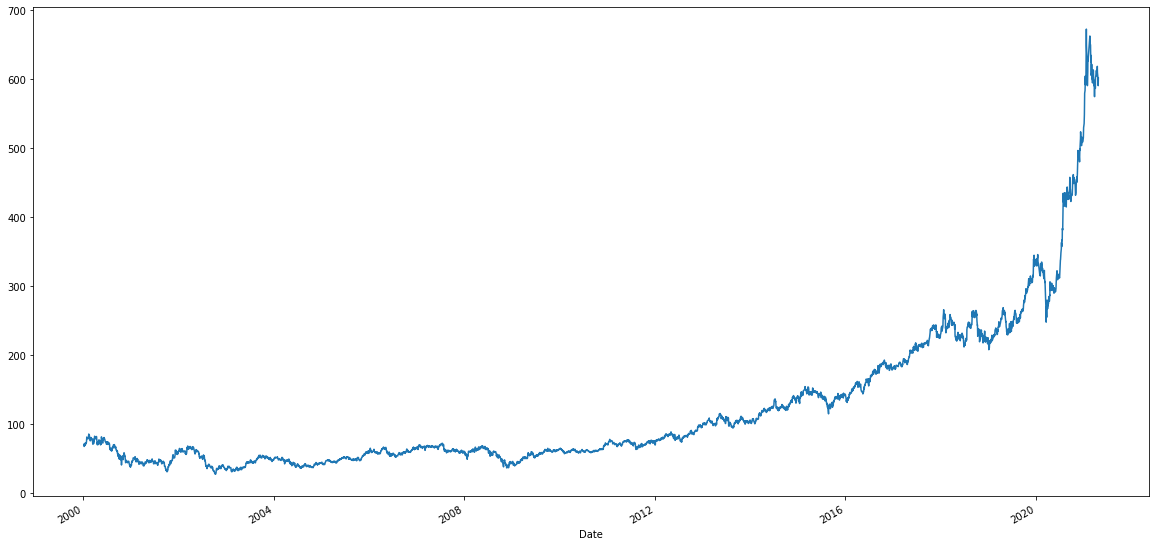

In [4]:
df['Close'].plot(kind = 'line', figsize = [20,10])

In [5]:
dataset = df[['Close']].values

In [6]:
dataset

array([[ 69.64903259],
       [ 71.21404266],
       [ 69.64903259],
       ...,
       [592.        ],
       [591.        ],
       [602.        ]])

### 資料標準化

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled  = sc.fit_transform(dataset)

In [8]:
dataset_scaled

array([[0.06535691],
       [0.06778124],
       [0.06535691],
       ...,
       [0.87452396],
       [0.87297487],
       [0.89001483]])

### 將資料區分為訓練與測試資料集

In [9]:
dataset_scaled.shape

(5325, 1)

In [10]:
5325 * 0.8

4260.0

In [11]:
import numpy as np
X_train = []
y_train = []
for i in range(60,4000):
  X_train.append(dataset_scaled[i-60:i ,0 ])
  y_train.append(dataset_scaled[i   ,0])

In [12]:
len(X_train), len(y_train)

(3940, 3940)

In [13]:
X_test = []
y_test = []

for i in range(4000 - 60,len(dataset_scaled)):
  X_test.append(dataset_scaled[i-60:i,0])
  y_test.append(dataset_scaled[i,0])

In [14]:
len(X_test), len(y_test)

(1385, 1385)

In [15]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
X_train.shape, X_test.shape

((3940, 60), (1385, 60))

### 運用機器學習建立模型 (選項)

In [35]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [36]:
pred_y = clf.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test, pred_y)

0.06111056562243642

In [41]:
r2_score(y_test, pred_y)

-0.9403733798194454

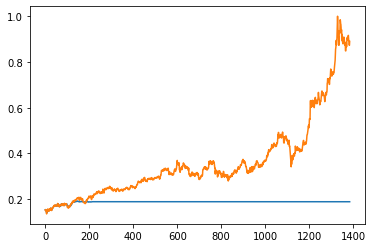

In [43]:
from matplotlib import pyplot as plt
plt.plot(range(len(pred_y)), pred_y)
plt.plot(range(len(y_test)), y_test)

### ===========================================

### Speech Recognition
- https://github.com/ywchiu/tibamedl/blob/master/CNN/Speech%20Recognition%20With%20Keras.ipynb

- https://github.com/kaldi-asr/kaldi
- https://github.com/alphacep/vosk-api
- https://github.com/mozilla/DeepSpeech

### 資料轉換

In [17]:
X_train  = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [18]:
# (資料筆數, 時間區間, 維度)
X_train.shape, X_test.shape

((3940, 60, 1), (1385, 60, 1))

### 建立 LSTM 模型

In [19]:
! nvidia-smi

Sat Apr 24 03:08:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    32W / 250W |    351MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [21]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)               

In [ ]:
regressor.compile(optimizer = 'adam', 
        loss = 'mean_squared_error')

regressor.fit(X_train, y_train, 
      epochs = 20, 
      batch_size = 32)

In [25]:
pred_y = regressor.predict(X_test)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(pred_y, y_test)

0.0010280285678320466

## R2_score
1 - ( SSE / SST )

In [27]:
r2_score(pred_y, y_test)

0.9566259230358042

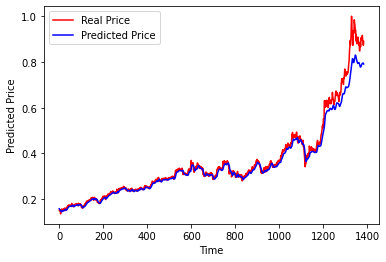

In [28]:
from matplotlib import pyplot as plt

plt.plot(y_test, color = 'red', label = 'Real Price')
plt.plot(pred_y, color = 'blue', label = 'Predicted Price')

plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

In [30]:
y_test.reshape(-1,1)

array([[0.15264945],
       [0.14955128],
       [0.15264945],
       ...,
       [0.87452396],
       [0.87297487],
       [0.89001483]])

In [31]:
y_real_test = sc.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_test = sc.inverse_transform(pred_y.reshape(-1,1)).flatten()

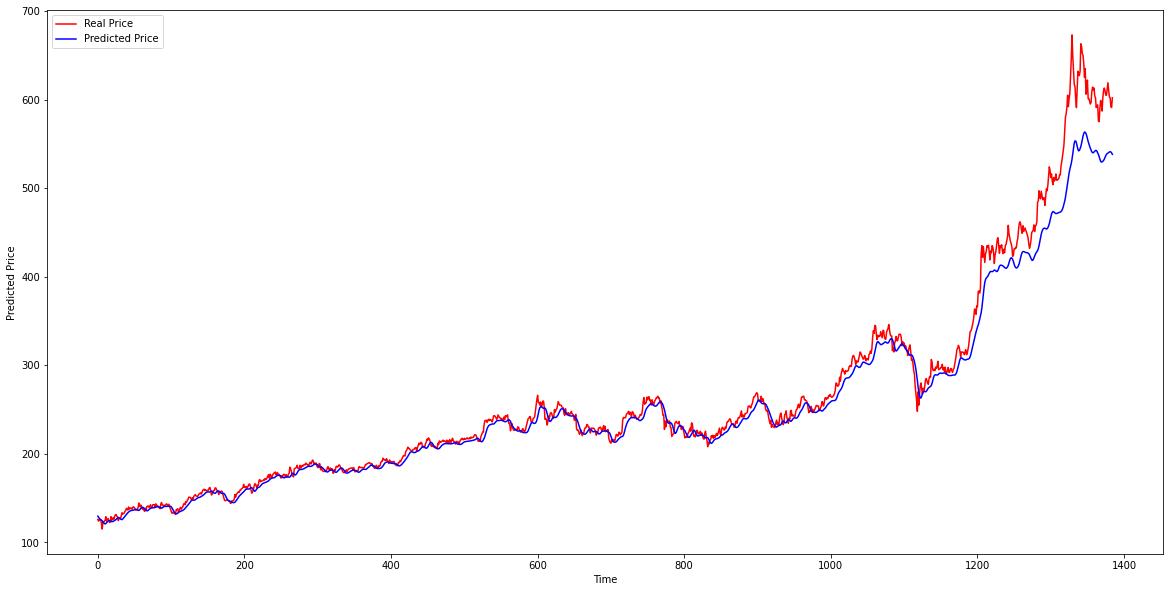

In [34]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(y_real_test, color = 'red', label = 'Real Price')
plt.plot(y_pred_test, color = 'blue', label = 'Predicted Price')

plt.xlabel('Time')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

## 多變數時間序列預測

In [35]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [36]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)

In [37]:
dataset = dataset[24:]

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
dataset['wnd_dir']= encoder.fit_transform(dataset['wnd_dir'])
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [42]:
values = dataset.values

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [44]:
import pandas
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [45]:
reframed = series_to_supervised(scaled, 1, 1)

In [46]:
reframed.shape

(43799, 16)

In [47]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545455,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563636,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563636,0.666667,0.009912,0.074074,0.0,0.109658


In [48]:
values = reframed.values
n_train_hours = 365 * 24

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [49]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, return_sequences = True))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, 
          epochs=50, 
          batch_size=72, 
          validation_data=(test_X, test_y), 
          verbose=1, 
          shuffle=False)